In [1]:
import warnings
warnings.filterwarnings('ignore')
from random import choice, uniform, seed;
import numpy as np
from numpy import array, zeros, ones, ndarray, where, isnan, inf, intersect1d, block
import matplotlib.pyplot as plt
import scienceplots 
import matplotlib.ticker as mtick
import pandas as pd
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from SGD import GradientDescent
from Kernel import LinearKernel, RBFKernel, PolyKernel

%matplotlib inline

In [2]:
data_final = pd.read_csv('data_final.csv')
data_final

,Unnamed: 0,wd,dem,rainfall_0,rainfall_1,rainfall_2,rainfall_3,rainfall_4,rainfall_5,rainfall_6,...,TRI_hx,NDVI_hx,TWI_hx,STI_hx,SPI_hx,nj_land_cover_hx,Rn_hx,nj_impervious_pro_hx,soil_type_hx,first_second_wd
0,3643,66.0,7.539524,1.148372,6.754024,0.660457,0.0,0.000000,1.979080,0.000000,...,6.082763,5165,12.506177,0.000000,-1.309333,80,0.000000,0,65535,65.723630
1,3644,10.0,10.246517,1.076423,6.175512,0.618174,0.0,0.000000,1.893723,0.000000,...,1.732051,5892,12.388394,0.000000,-1.427116,13,0.210819,0,65535,12.841298
2,3852,18.0,7.321353,0.878226,4.965781,0.682901,0.0,1.432295,1.949567,0.000000,...,1.732051,5508,12.506177,0.000000,-1.309333,15,0.210819,0,65535,38.483765
3,3853,10.0,7.689694,0.900899,4.005706,0.682912,0.0,1.448326,1.824051,0.000000,...,2.449490,5526,12.388394,0.000000,-1.427116,50,0.129099,0,65535,16.324364
4,4060,10.0,7.328392,0.920031,5.058594,0.697206,0.0,1.406655,1.959472,0.000000,...,1.732051,4745,18.473747,0.000000,4.658237,20,0.210819,0,65535,16.804430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11946,395125,219.0,6.829740,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.009520,...,5.477226,5569,7.842116,1.194826,1.732868,80,0.516398,1,22,177.197270
11947,395334,10.0,8.435632,0.300252,0.000000,0.000000,0.0,0.000000,0.000000,1.035505,...,4.472136,4297,7.828416,0.704563,1.171203,75,0.387298,1,22,14.031875
11948,395542,10.0,14.501780,0.297582,0.000000,0.000000,0.0,0.000000,0.000000,1.008315,...,2.645751,2816,14.166474,1.023366,3.898344,80,0.258199,1,22,12.285815
11949,397200,10.0,7.436702,0.318690,0.000000,0.000000,0.0,0.000000,0.000000,0.505950,...,4.582576,3582,6.203543,0.721257,0.598851,80,0.000000,1,22,12.490312


In [3]:
# Lance Distance
def LanceDistance(x, y):
    d = np.sum(abs(x - y) / (abs(x) + abs(y) + 1e-20))
    return d

# Manhattan Distance
def ManhattanDistance(x, y):
    return np.sum(np.abs(x-y))

# Chebyshev Distance
def ChebyshevDistance(x, y):
    return np.max(np.abs(x-y))

# Adjusted Cosine
def AdjustedCosine(vector_a, vector_b):
    cosine_similarity = np.dot(vector_a, vector_b) / (np.linalg.norm(vector_a) * np.linalg.norm(vector_b))
    corrected_similarity = cosine_similarity * (1 / len(vector_b))
    return np.sum(corrected_similarity)

In [4]:
# test
from statsmodels.stats.outliers_influence import variance_inflation_factor

neigh_num = 27
first_step_factors = ['wd','dem', 'soil_type_hx']

for i in range(8):
    first_step_factors.append(f'neigh_dem_{i}')
    first_step_factors.append(f'neigh_rain_{i}')

for i in range(neigh_num):
    first_step_factors.append('rainfall_' + str(i))

y_second_label = 'wd_dif'
data_final[y_second_label] = data_final['wd'] - data_final['first_second_wd']

second_step_factors = list(set(data_final.columns.tolist()).difference(set(first_step_factors)))

data_final_second = data_final.loc[:, second_step_factors]
data_final_dummy = data_final_second.copy()

second_cols = data_final_dummy.columns.to_list()
data_final_second = data_final_dummy[second_cols]

In [5]:
data_final_second.drop_duplicates()
data_final_second1= data_final_second.query('slope_hx>=0 & R_hx>=0 & Rn_hx>=0 & RI_hx>=0 \
             & NDVI_hx>=-9999 & NDVI_hx<=9999 & nj_land_cover_hx>0 \
             & nj_impervious_pro_hx<=3')  # & soil_type_hx<65535
second_index = data_final_second1['Unnamed: 0'].tolist()
data_final_second1.drop(['Unnamed: 0'], axis=1, inplace=True)
second_cols = data_final_second1.columns.tolist()
data_final_second1

,STI_hx,RI_hx,SPI_hx,NDVI_hx,TWI_hx,first_second_wd,plane_cur_hx,profile_cur_hx,Rn_hx,aspect_hx,TPI_hx,slope_hx,wd_dif,nj_land_cover_hx,TRI_hx,R_hx,nj_impervious_pro_hx
0,0.000000,6.082763,-1.309333,5165,12.506177,65.723630,34.258224,0.594871,0.000000,1,-0.875,0.000000,0.276370,80,6.082763,6.0,0
1,0.000000,1.732051,-1.427116,5892,12.388394,12.841298,0.000000,0.000000,0.210819,1,-0.375,0.000000,-2.841298,13,1.732051,1.0,0
2,0.000000,1.732051,-1.309333,5508,12.506177,38.483765,0.000000,0.000000,0.210819,1,-0.375,0.000000,-20.483765,15,1.732051,1.0,0
3,0.000000,2.449490,-1.427116,5526,12.388394,16.324364,0.000000,0.000000,0.129099,1,0.000,0.000000,-6.324364,50,2.449490,2.0,0
4,0.000000,1.732051,4.658237,4745,18.473747,16.804430,0.000000,0.000000,0.210819,1,-0.375,0.000000,-6.804430,20,1.732051,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11946,1.194826,5.477226,1.732868,5569,7.842116,177.197270,55.126740,3.483012,0.516398,11,-0.500,2.698951,41.802730,80,5.477226,6.0,1
11947,0.704563,4.472136,1.171203,4297,7.828416,14.031875,43.795937,3.508281,0.387298,11,-0.250,2.052775,-4.031875,75,4.472136,5.0,1
11948,1.023366,2.645751,3.898344,2816,14.166474,12.285815,75.553240,1.980757,0.258199,11,-0.375,0.337615,-2.285815,80,2.645751,3.0,1
11949,0.721257,4.582576,0.598851,3582,6.203543,12.490312,79.811905,1.272555,0.000000,17,0.375,3.471741,-2.490312,80,4.582576,4.0,1


Remove  373  outlier(s)


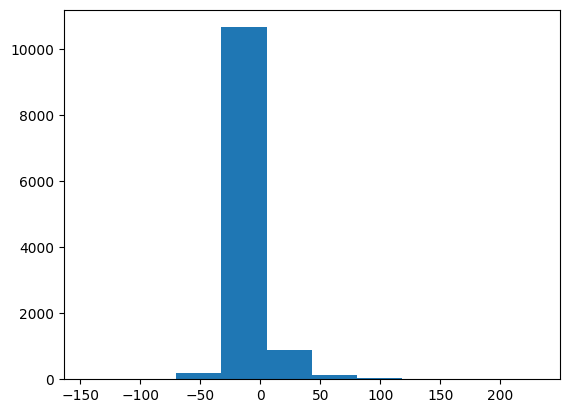

In [6]:
plt.hist(data_final_second1[y_second_label])

# remove outliers
def rmvoutlier(x, coef = 2.5):
    k = np.where((np.isnan(x)) | \
    (x > (np.nanmean(x) + coef * np.nanstd(x))) | (x < (np.nanmean(x) - coef * np.nanstd(x))))
    if(len(k)>0):
        print('Remove ', len(k[0]), ' outlier(s)')
    else:
        print('No outlier')
    
    return k

k = rmvoutlier(data_final_second1[y_second_label])
# print(k)

dt = data_final_second1.iloc[~data_final_second1.index.isin(k[0]), :]
second_index = np.delete(np.asarray(second_index), k[0])

X = np.matrix(dt)
VIF_list = np.asarray([variance_inflation_factor(X, i) for i in range(0, X.shape[1])])
X_VIF = X[:, VIF_list < 10]

In [7]:
labels = np.asarray(second_cols)[np.argwhere(VIF_list < 10).flatten()]
labels_list =  labels.tolist()
if 'first_second_wd' not in labels_list:
    labels_list.append('first_second_wd')
labels_list.remove('wd_dif')

X_pd = pd.DataFrame(X_VIF, columns=labels)
X_pd_index = np.random.choice(np.arange(X_pd.shape[0]), int(np.round(X_pd.shape[0]*0.5)), replace=False)
X_pd_part = X_pd.iloc[X_pd_index, :]

# determine the best kappa

start = time.perf_counter()

formula = y_second_label + ' ~ '
# generate a formula by extracting explanatory variables in the second step.
for v in labels_list:
    formula += v + ' + '
formula = formula[:-2]

In [16]:
from sklearn.metrics import median_absolute_error


class SigmoidKernel:
    """
    Sigmoid kernel function
    gamma is 1 / (n_features * X.var()
    sigmoid(x, y) = tanh(gamma * (x.T @ y))
    """
    # For time reasons, the simple code form is used here and the various dimensions are not taken into account 
    def __call__(self, X__: ndarray, Z__: ndarray) -> ndarray:
        self.gamma = 1 / (X__.shape[1] * X__.var())
        if X__.ndim==1 and 1<=Z__.ndim<=2:     # if X__ is 1D ndarray and Z__ is 1D or 2D ndarray
            return np.tanh(self.gamma *(Z__ @ X__))
        elif 1<=X__.ndim<=2 and Z__.ndim==1:   # if Z__ is 1D ndarray and X__ is 1D or 2D ndarray
            return np.tanh(self.gamma * (X__ @ Z__))
        elif X__.ndim==2 and Z__.ndim==2:      # if X__ and Z__ are 2D ndarray
            K__ = zeros([len(X__), len(Z__)])  # kernel function value matrix
            for n, x_ in enumerate(X__):
                K__[n] = np.tanh(self.gamma * (Z__ @ x_))
            return K__
        else:
            raise ValueError('input X__ and Z__ should be ndarray and their attributes ndim should be 1 and 2')

        # return np.tanh(self.gamma * (X__.T @ Z__))

class SupportVectorRegression:
    """Supprot Vector Reression"""
    def __init__(self,
            C: float = 1.,    # penalty parameter
            ε: float = 1.,    # The spacer band width is 2ε
            kernel: str = 'linear',      # kernel function：optional 'linear'/'RBF'/'poly'
            solver: str = 'SMO',         # Solver：optional 'SMO'/'Pegasos'
            maxIterations: int = 10000,  # max iteration
            tol: float = 1e-3,  # convergence precision（The maximum violation of KKT conditions in SMO Solver）
            LR: float = 1.,     # learning rate user for Pegasos Solver）
            d: int = 2,         # Exponents of polynomial kernel functions
            γ: float = 1.,      # Parameters of Gaussian kernel function and polynomial kernel function
            r: float = 1.,      # Parameters of a polynomial kernel function
            ):
        assert C>0, 'C should be more than 0'
        assert ε>0, 'ε should be more than 0'
        assert type(maxIterations)==int and maxIterations>0, 'maxIterations should be positive integer'
        assert tol>0, 'tol should be more than 0'
        assert LR>0, 'LR should be more than 0'
        assert type(d)==int and d>=1, 'd should be positive integer'
        assert γ>0, 'Parameters of Gaussian kernel function and polynomial kernel function γ should be positive integer'
        self.C = C   
        self.ε = ε   
        self.kernel = kernel.lower()        
        self.solver = solver.lower()        
        self.maxIterations = maxIterations  
        print(maxIterations, self.maxIterations, 'maxIterations init')
        self.tol = tol       
        self.LR = LR         
        self.d = d           
        self.γ = γ           
        self.r = r           
        self.M = None        # Dimension of the input feature vector
        self.w_ = None       # M-dimensional vector: weight vector
        self.b = None        # bias
        self.α_ = None       # N-dimensional vector: Lagrange multiplier of N training samples
        self.αhat_ = None    # N-dimensional vector: Lagrange multiplier of N training samples
        self.ΔαSV_ = None    # N-dimensional vector: αhat-α values corresponding to all support vectors
        self.supportVectors__ = None  # Matrix: All support vectors
        self.αSV_ = None     # Vector: The Lagrange multiplier α of all support vectors
        self.ySV_ = None     # Vector: Labels corresponding to all support vectors
        self.loss_arr = [] # Record the value of the loss function for each iteration
        self.minimizedObjectiveValues_ = None  # List: minimizing the value of the objective function (for the Pegasos algorithm, 
                                                # the value of the loss function; For SMO solving algorithm, refers to the minimum objective 
                                                # function value of the dual problem)
        """the selction of kernel function"""
        if self.kernel=='linear':
            self.kernelFunction = LinearKernel()
            print('Linear kernel function is used')
        elif self.kernel=='poly':
            self.kernelFunction = PolyKernel(d=self.d, γ=self.γ, r=self.r)
            print('Poly kernel function is used')
        elif self.kernel=='rbf':
            self.kernelFunction = RBFKernel(γ=self.γ)
            print('RBF kernel function is used')
        elif self.kernel=='sigmoid':
            self.kernelFunction = SigmoidKernel()
            print('Sigmoid kernel function is used')
        else:
            raise ValueError(f"kernel function is not defined: '{kernel}'")
        
        """the selction of Solver"""
        if self.solver=='smo':
            print('SMO Solver is used')
        elif self.solver=='pegasos':
            assert self.kernel=='linear', "The Pegasos (gradient descent) algorithm can be called only if the linear kernel function 'linear' is used"
            print('Pegasos Solver is used')
        else:
            raise ValueError(f"Solver is not defined: '{self.solver}'")

    def fit(self, X__: ndarray, y_: ndarray):
        """Training: Use the SMO or Pegasos Solver for training"""
        assert type(X__)==ndarray and X__.ndim==2, 'The input training sample matrix X should be 2D ndarray'
        assert type(y_)==ndarray  and y_.ndim==1, 'The input training label y should be 1D ndarray'
        assert len(X__)==len(y_), 'The number of input training samples should equal the number of labels'
        self.M = X__.shape[1]   # Dimension of the input feature vector
        if self.solver=='smo':  # Use SMO Solver for training
            self.SMO(X__, y_)
        elif self.solver=='pegasos':  # Use Pegasos Solver for training
            self.Pegasos(X__, y_)
        return self

    def Pegasos(self, X__: ndarray, y_: ndarray):
        """Pegasos (Primal estimated sub-gradient solver) algorithm, namely gradient descent method, is used to solve 
        the original optimization problem and minimize the loss function"""
        C = self.C        
        ε = self.ε        
        N, M = X__.shape  # The number of training samples N, the dimension of input feature vector M
        w_ = ones(M)      # M-dimensional vector: initializes the weight vector
        b = array([0.])   # Initialize the bias (since bias b needs to load the gradient descent optimizer, it is defined as 1-dimensional ndarray first, and then the bias b is extracted as float after optimization)
        optimizer_for_w_ = GradientDescent(w_, method='Adam', LR=self.LR)  # The gradient descent optimizer of w is instantiated, the global learning rate LR is substituted, and the Adam learning rate adjustment strategy is selected
        optimizer_for_b  = GradientDescent(b,  method='Adam', LR=self.LR)  # The gradient descent optimizer of b is instantiated, the global learning rate LR is substituted, and the Adam learning rate adjustment strategy is selected
        minLoss = inf  # Initializes the minimum loss function value
        self.minimizedObjectiveValues_ = losses_ = []  # List: Records the loss function values for each iteration
        ξ_ = zeros(N)  # N-dimensional vector: initializes N relaxation variables
        for t in range(1, self.maxIterations+1):
            Δ_ = X__ @ w_ + b - y_   # N-dimensional vector: N residuals; Residual = predicted value - true value
            ξ_[Δ_>ε] = Δ_[Δ_>ε] - ε  # N-dimensional vector: N relaxation variables
            ξ_[(-ε<=Δ_) & (Δ_<=ε)] = 0.
            ξ_[Δ_<-ε] = -Δ_[Δ_<-ε] - ε
            loss = 0.5*w_ @ w_ + C*sum(ξ_)  # Loss function
            gradw_ = w_ + C*(X__[Δ_>ε].sum(axis=0) - X__[Δ_<-ε].sum(axis=0))  # M-dimensional vector: gradient of the loss function to the weight vector w
            gradb = C*((Δ_>ε).sum() - (Δ_<-ε).sum())                          # The gradient of the loss function biased against b
            losses_.append(loss)                      # Record loss function values
            if loss<minLoss:
                minLoss = loss         # Record the historical minimum loss function ε
                wOptimal_ = w_.copy()  # Record the historical optimal weight vector w_
                bOptimal = b.copy()    # Record historical optimal bias b
            self.loss_arr.append(loss)
            # print(f'{t} iteration, loss function value {loss:.5g}')
            # Gradient descent, update the weight vector w and bias b
            optimizer_for_w_.update(gradw_)  # Plug in the gradient to the optimizer and update the weight vector w_
            optimizer_for_b.update(gradb)  # Plug in the gradient to the optimizer and update the weight vector b
        else:
            print(f'The maximum number of iterations is reached: {self.maxIterations}')
        
        print(f'\tThe loss function value of the last iteration: {loss}')
        print(f'\tThe minimum loss function value of successive iterations: {minLoss}')
        self.w_ = wOptimal_.copy()       # The historically optimal weight vector is used as the training result
        self.b = bOptimal.copy().item()  # The historically optimal bias is used as the training result

    def SMO(self, X__: ndarray, y_: ndarray):
        """The Sequential Minimal Optimization (SMO) algorithm is used to solve the dual optimization problem and minimize the objective function"""
        C = self.C      
        ε = self.ε      
        N = len(X__)    # Number of training samples
        c_ = block([y_ - ε, -(y_ + ε)])      # 2n-dimensional vector: Introduce vector c_
        z_ = block([ones(N), -ones(N)])      # 2n-dimensional vector: Introduce vector z_
        K__ = self.kernelFunction(X__, X__)  # N×N matrix: kernel function matrix
        K__ = block([[K__, K__],
                     [K__, K__]])  # 2N×2N matrix: An extended kernel function matrix
        λ_ = zeros(2*N)  # 2n-dimensional vector: initializes 2N Lagrange multipliers,  αhat and α
        b = 0            # Initialize the bias
        self.minimizedObjectiveValues_ = []  # List: Records the value of the objective function for each iteration
        
        minimizedObjectiveValue = 0.5*λ_ @ (z_*K__*z_.reshape(-1, 1)) @ λ_ - λ_ @ c_   # Initialization: The value of the objective function
        
        for t in range(1, self.maxIterations + 1):
            indexSV_ = where(λ_>0)[0]                   # Array index: Support vector that satisfies λ_>0
            indexNonBound_ = where((0<λ_) & (λ_<C))[0]  # Array index: Support vector that satisfies 0<λ_<C
            self.minimizedObjectiveValues_.append(minimizedObjectiveValue)  # Records the current objective function value
            """Test whether all 2N λ satisfy the KKT condition, and calculate the extent to which each λ violates the KKT condition"""

            g_ = (λ_[indexSV_]*z_[indexSV_]) @ K__[indexSV_, :] + b  # 2n-dimensional vector: g(xi) values, i = 0~2N-1
            zg_ = z_*g_                                   # 2n-dimensional vector: zi*g(xi), i = 0~2N-1
            
            violateKKT_ = abs(c_ - zg_)                   # 2n-dimensional vector: Start calculating "The degree of violation of KKT condition"
            violateKKT_[(λ_==0) & (zg_>=c_)] = 0.         # 2n-dimensional vector: KKT condition λ_=0 ←→ z*g(x)≥c
            violateKKT_[(0<λ_) & (λ_<C) & (zg_==c_)] = 0. # 2n-dimensional vector: KKT condition 0<λ<C ←→ z*g(x)=c
            violateKKT_[(λ_==C) & (zg_<=c_)] = 0.         # 2n-dimensional vector: KKT condition λ_=C ←→ z*g(x)≤c
            
            self.loss_arr.append(violateKKT_.max())
            if violateKKT_.max()<self.tol:
                print(f'For the {t} SMO iteration, the maximum violation of KKT condition reaches convergence accuracy {self.tol}, stop iteration!')
                break
            """select λi"""
            indexViolateKKT_ = where(violateKKT_>0)[0]    # Array index: Find λ that violates the KKT condition
            indexNonBoundViolateKKT_ = intersect1d(indexViolateKKT_, indexNonBound_)  # Array index: Find nonboundary λ that violates the KKT condition
            
            if uniform(0, 1)<0.85:
                # There is a high probability (85%) to select the λ with the greatest degree of violation of KKT conditions for the next optimization. If there is a non-boundary λ, the non-boundary λ is preferred
                if len(indexNonBoundViolateKKT_)>0:
                    # If there is a non-boundary λ that violates the KKT condition, the non-boundary λ with the greatest violation of the KKT condition is chosen
                    i = indexNonBoundViolateKKT_[violateKKT_[indexNonBoundViolateKKT_].argmax()]
                else:
                    # If there is no non-boundary λ that violates the KKT condition, then the λ with the greatest violation of the KKT condition is directly selected
                    i = violateKKT_.argmax()
            else:
                # Retain a small probability (15%) of randomly selecting λ that violates the KKT condition
                i = choice(indexViolateKKT_)

            """select λj"""
            j = choice(indexViolateKKT_)  # Randomly select another λ that violates the KKT condition
            ii = i-N if i>N-1 else i      # Because the i th λ corresponds to the same sample as the i+N λ
            jj = j-N if j>N-1 else j      # Because the JTH λ corresponds to the same sample as the JTH + NTH λ

            while (X__[ii]==X__[jj]).all():
                j = choice(range(N))      #  The selected samples X__[i] and X__[j] are identical, and λj is selected again
                jj = j-N if j>N-1 else j      
            """optimize λi、λj"""
    
            λiOld, λjOld = λ_[i], λ_[j]   # Record the old values of λi, λj

            if z_[i]!=z_[j]:              # Determine the lower limit L and upper limit H of λj
                L, H = max(0, λjOld - λiOld), min(C, C + λjOld - λiOld)
            else:
                L, H = max(0, λjOld + λiOld - C), min(C, λjOld + λiOld)

            Kii = K__[i, i]  # Reads the kernel function value from the kernel matrix
            Kjj = K__[j, j]  # Reads the kernel function value from the kernel matrix
            Kij = K__[i, j]  # Reads the kernel function value from the kernel matrix

            Ei = g_[i] - c_[i]*z_[i]   # error value Ei
            Ej = g_[j] - c_[j]*z_[j]   # error value Ej

            η = Kii + Kjj - 2*Kij      # ||φ(xi)-φ(xj)||**2 >= 0
            λj = λjOld + z_[j]*(Ei - Ej)/η  # uncut λj

            if λj>H:     # cutted λj
                λj = H
            elif λj<L:
                λj = L
            else:
                pass
            λi = λiOld + z_[i]*z_[j]*(λjOld - λj) # uncut λi
            if λi>C:     # cutted λi
                λi = C
            elif λi<0:
                λi = 0
            else:
                pass

            λ_[i], λ_[j] = λi, λj  # update λi、λj
            """update objective function value"""
            vi = g_[i] - λiOld*z_[i]*Kii - λjOld*z_[j]*Kij - b  # vi
            vj = g_[j] - λiOld*z_[i]*Kij - λjOld*z_[j]*Kjj - b  # vj

            minimizedObjectiveValue += (0.5*(λi**2 - λiOld**2)*Kii
                                     + 0.5*(λj**2 - λjOld**2)*Kjj
                                     + (λi*λj - λiOld*λjOld)*Kij*z_[i]*z_[j]
                                     + vi*z_[i]*(λi - λiOld)
                                     + vj*z_[j]*(λj - λjOld)
                                      ) - ((λi - λiOld)*c_[i] + (λj - λjOld)*c_[j])  # Update the objective function value
            """update bias Sb"""

            if 0<λi<C:
                b =  -Ei - z_[i]*Kii*(λ_[i] - λiOld) - z_[j]*Kij*(λ_[j] - λjOld) + b
            elif 0<λj<C:
                b =  -Ej - z_[i]*Kij*(λ_[i] - λiOld) - z_[j]*Kjj*(λ_[j] - λjOld) + b
            else:
                bi = -Ei - z_[i]*Kii*(λ_[i] - λiOld) - z_[j]*Kij*(λ_[j] - λjOld) + b
                bj = -Ej - z_[i]*Kij*(λ_[i] - λiOld) - z_[j]*Kjj*(λ_[j] - λjOld) + b
                b = (bi + bj)/2
            if isnan(b):
                raise ValueError('bias b is nan，error！')
        else:
            print(f'max iteration{self.maxIterations}，stop iteration!')
        """The optimization is over. Calculate offset b"""
        self.αhat_ = λ_[:N]                                    
        self.α_ = λ_[N:]                                       
        indexSV_ = where(self.αhat_!=self.α_)[0]               # Numerical index: all support vectors
        self.ΔαSV_ = self.αhat_[indexSV_] - self.α_[indexSV_]  # Vector: αhat-α value corresponding to the support vector
        self.supportVectors__ = X__[indexSV_]                  # Matrix: All support vectors
        self.ySV_ = y_[indexSV_]                               # Vector: Labels corresponding to all support vectors
        indexNonBound_ = where((0<self.α_) & (self.α_<C))[0]   # Array index: satisfies alpha of 0<α<C
        if len(indexNonBound_)>0:
            # If there is an α that satisfies 0<α<C, the offset b is calculated and the average is taken
            b_ = [y_[k] + ε - self.ΔαSV_ @ K__[k][indexSV_] for k in indexNonBound_]
            self.b = sum(b_)/len(b_)  # Take the bias b mean
        else:
            self.b = b
            print('There is no α satisfying 0<α<C, take the bias b obtained from the last iteration.')
        """Calculate the weight vectorw_"""
        if self.kernel=='linear':
            # 若使用线性核函数，计算权重向量
            self.w_ = np.dot(self.ΔαSV_, self.supportVectors__)
  
    def predict(self, X__: ndarray) -> ndarray:
        """test"""
        assert type(X__)==ndarray and X__.ndim==2, 'Input test sample matrix X should be 2-dimensional ndarray'
        assert X__.shape[1]==self.M, f' Input test sample dimension should be equal to training sample dimension {self.M}'
        if self.solver=='smo':
            # If the SMO is used to train
            y_ = self.ΔαSV_ @ self.kernelFunction(self.supportVectors__, X__) + self.b
        elif self.solver=='pegasos':
            # If the Pegasos is used to train
            y_ = X__ @ self.w_ + self.b
        return y_, self.loss_arr

def run_model(first_wd, X_train, X_test, y_train, y_test1, y_normalizer, kernel='linear', solver='SMO'):
    model = SupportVectorRegression(
    C=1,    
    ε=0.001,    
    kernel=kernel,      
    solver=solver,         
    maxIterations=150000,  
    tol=0.001,  
    LR=0.01,   
    d=2,      
    γ=1.,      
    r=1.,     
    )
    
    print(X_train.shape, y_train.shape, X_test.shape, y_test1.shape)
    model.fit(X_train, y_train.reshape(-1))  # train
    y_pred, loss_arr = model.predict(X_test)  # test
    y_pred1 = y_pred.reshape(-1, 1)
    y_pred2_inversed = y_normalizer.inverse_transform(y_pred1.reshape(-1, 1))
    y_test2_add, y_pred2_add = (y_test1 + first_wd).reshape(-1, 1), (y_pred2_inversed + first_wd).reshape(-1, 1)
    print(f"{kernel} R_squared:{r2_score(y_test2_add, y_pred2_add):.10f}")
    print(f"{kernel} RMSE:{mean_squared_error(y_test2_add, y_pred2_add, squared=False):.10f}")
    print(f"{kernel} MAE:{mean_absolute_error(y_test2_add, y_pred2_add):.10f}")
    print(f"{kernel} MAD:{median_absolute_error(y_test2_add, y_pred2_add):.10f}")
    return y_test2_add, y_pred2_add, r2_score(y_test2_add, y_pred2_add), loss_arr, model

In [9]:

## gos
def gos(formula, data=None, newdata=None, kappa=0.25, kernel='linear', epsilon=np.exp(-12)):
    print(f"kappa:{kappa}")
    tau = 1 - kappa
    formula = formula.split('~') # convert it to list
    formula = [a.strip() for a in formula]  # remove before and after spaces
    y_train = data.loc[:,[formula[0]==a for a in data.columns]] # judge whether colnames(data) == y factor
    y_train = np.asarray(y_train)
    y_test = newdata.loc[:,[formula[0]==a for a in newdata.columns]] # judge whether colnames(data) == y factor
    y_test  = np.asarray(y_test)
    test_row = newdata.shape[0] # get row numver of test data

    # obs_explanatory means explanatory X variables at observation.
    if(formula[1]=="."): # judge whether it is . (I do not know the reason of the judgement)
        len_col = data.shape[1] - 1 # get col number of data
        X_train = data.drop(formula[0], axis=1) # drop y factor
        X_test = newdata.drop(formula[0], axis=1)
        
    else:
        col = formula[1].split('+')
        col = [a.strip() for a in col] # remove before and after spaces
        len_col = len(col) # get the length of the last of all variables of data note: A series of variables after ~ (independent variable)
        X_train = data.loc[:, col]
        X_test = newdata.loc[:, col]

    print(X_train.columns)
    first_wd = X_test['first_second_wd'].values.reshape(-1, 1)
    X_train = X_train.drop(columns=['first_second_wd'])
    X_test = X_test.drop(columns=['first_second_wd'])
    X_normalizer = StandardScaler() # N(0,1)
    X_train = X_normalizer.fit_transform(X_train)
    X_test = X_normalizer.transform(X_test)
    
    print(X_train.shape, X_test.shape, len_col, 'shape:')
    xall = pd.concat((pd.DataFrame(X_train), pd.DataFrame(X_test)), axis=0)   # concatenate two parts for calculation of sigma (like 6) of eq. 3
    sdv = xall.std()   # calculate std across each column
    
    ej_final = 0
    for u in range(test_row): # test the performance of the model
        yobs = y_train
        xobsmatrix = X_train # obtain all values from observation explanation
        xpredvalues = X_test[u] # obtain all values at each row from predictive explanation

        # 未知数据与已知所有数据进行计算 (按照列) (col_number, train_data_number)
        ej1 = [Ej(xobsmatrix[:, i], xpredvalues[i], test_row, sdv[i]) for i in range(len_col-1)] # calculate according to eq. 3  # Then change into the multi-similarity formula (cosine, EU distances, Pearson similarity and so on)

        ej = np.nanmean(ej1, axis=0) # calculate according to eq. 2. P function is minimum operator (train_data_number)
        k = (ej <= np.nanquantile(ej, tau)) # calculate index according to S_lambda(u_alpha, v_beta) > S_lambda

        ej2 = ej[k] # ej2 is S_lambda(u, v_β)

        ej_final = ej_final + np.sum(yobs[k] * ej2) / (np.sum(yobs[k]) + epsilon) / len(yobs[k])

    ej_final /= test_row
    y_normalizer = StandardScaler()
    y_train1 = y_normalizer.fit_transform(y_train.reshape(-1, 1))
    y_train2 = y_train1 * ej_final.reshape(-1, 1)

    y_test1, y_pred1, r2, loss_arr, model = run_model(first_wd, X_train, X_test, y_train2, y_test, y_normalizer, kernel)

    return y_test1, y_pred1, r2, loss_arr, model, X_normalizer, y_normalizer

def Ej(xobs, xp1, snp, sdv, thres=1e-3):    # calculate according to eq. 3
    """
    xobs: observed values of x variables
    xp1: predictive values of x variables
    snp: rows of test data
    sdv: standard deviation of all oberseved values and predictive values of x variables
    """
    # start_time = time.time()
    xp1 = np.repeat(xp1, len(xobs))
    xobs = np.asarray(xobs)
    ds = np.asarray([LanceDistance(xp1, xobs), ManhattanDistance(xp1, xobs), ChebyshevDistance(xp1, xobs), AdjustedCosine(xp1, xobs)])
    ds[np.isnan(ds)] = 0
    den = np.sqrt(snp)
    if np.max(ds) == 0:      
       sdj = thres / den
    else:
       sdj =  np.min(ds[ds > thres]) / den # calculate according to eq. 4 
    ej = np.exp(-((xp1 - xobs)) ** 2 * sdj / (2 * (sdv*sdv))) / (sdv * np.sqrt(2*np.pi))
    # print("--- %8f seconds ---" % (time.time() - start_time))
    return ej

## bestkappa
def bestkappa(formula, data, kernel='linear', kappa=np.arange(0.05, 1.05, 0.05), nrepeat=10):
    nrepeat = int(np.log(data.shape[0]))
    namey = formula.split('~')[0].strip() # obtain y label
    out = pd.DataFrame({'kappa':np.repeat(kappa, nrepeat),
                            'times':np.tile(np.arange(1, nrepeat+1), len(kappa)),
                             'rmse':np.repeat(None, nrepeat*len(kappa)),
                             'r2':np.repeat(None, nrepeat*len(kappa))})
    
    # 70% train 30% test Cross-velidation 10 times
    print(len(out), 'len(out)')
    for i in range(len(out)):
        print(f'i: {i}')
        np.random.seed(out.loc[i, 'times'])
        split = np.random.choice(np.arange(data.shape[0]), int(np.round(data.shape[0]*0.1)), replace=False)
        # split
        train = data.iloc[split, :]
        test = pd.concat([data, train, train]).drop_duplicates(keep=False)

        y_test, y_pred, r2, loss_arr, model, X_normalizer, y_normalizer = gos(formula, train, test, out.loc[i, 'kappa'], kernel) # obtrain optimal kappa parameter
        out.loc[i, 'rmse'] = mean_squared_error(test.loc[:, namey], y_pred, squared=False) # squared=False return RMSE
        out.loc[i, 'r2'] = r2_score(test.loc[:, namey], y_pred)
    
    # calculate the mean value of rmse at 10 times
    out1 = out.loc[:, ['kappa', 'rmse']].groupby('kappa').mean().reset_index()  
    out2 = out.loc[:, ['kappa', 'r2']].groupby('kappa').mean().reset_index()

    # plot selecting optimal threshold of similar locations
    k1 = np.where(out1['rmse'] == min(out1['rmse']))[0][0] # obtain the first index meeting the requirement according to eq. 9
    k2 = np.where(out2['r2'] == max(out2['r2']))[0][0] # obtain the first index meeting the requirement according to eq. 9
    best_kappa1 = out1.iloc[k1, :]
    best_kappa2 = out2.iloc[k2, :]

    best_x1 = out1.loc[k1, 'kappa']
    best_y1 = out1.loc[k1, 'rmse']

    out = {'bestkappa1': best_kappa1, 'bestkappa2': best_kappa2, 'cvrmse_r2':out, 'cvmean':out1, 'cvmeanr2':out2, 
           'best_x1':best_x1, 'best_y1':best_y1, 'plot':plt}
    return out, y_test, y_pred, r2, loss_arr

In [10]:
kernels = ['linear']    # , 'poly', 'rbf', 'sigmoid' # four kernels were run at different computers for acceleration

outs = []
for k in kernels:
    # for quan_ms in quantile_ms:
    tuple_ = bestkappa(formula, X_pd_part, kernel=k)
    outs.append(tuple_)

160 len(out)
i: 0
kappa:0.05
Index(['STI_hx', 'SPI_hx', 'NDVI_hx', 'first_second_wd', 'plane_cur_hx',
       'profile_cur_hx', 'Rn_hx', 'aspect_hx', 'TPI_hx', 'slope_hx',
       'nj_land_cover_hx', 'nj_impervious_pro_hx'],
      dtype='object')
(579, 11) (5210, 11) 12 shape:
150000 150000 maxIterations init
Linear kernel function is used
SMO Solver is used
(579, 11) (579, 1) (5210, 11) (5210, 1)
max iteration150000，stop iteration!
linear R_squared:0.9437021341
linear MSE:8.0236409925
linear MAE:4.3694984591
linear MAD:0.4806720780
i: 1
kappa:0.05
Index(['STI_hx', 'SPI_hx', 'NDVI_hx', 'first_second_wd', 'plane_cur_hx',
       'profile_cur_hx', 'Rn_hx', 'aspect_hx', 'TPI_hx', 'slope_hx',
       'nj_land_cover_hx', 'nj_impervious_pro_hx'],
      dtype='object')
(579, 11) (5210, 11) 12 shape:
150000 150000 maxIterations init
Linear kernel function is used
SMO Solver is used
(579, 11) (579, 1) (5210, 11) (5210, 1)
max iteration150000，stop iteration!
linear R_squared:0.9427456242
linear MSE:

In [17]:
import time

#gos

# all_split = np.arange(X_pd.shape[0])
# train_split = np.random.choice(all_split, int(np.round(X_pd.shape[0]*0.1)), replace=False)
# test_split = np.setdiff1d(all_split, train_split)

all_split_part = np.arange(X_pd_part.shape[0])
train_split_part = np.random.choice(all_split_part, int(np.round(X_pd_part.shape[0]*0.1)), replace=False)
test_split_part = np.setdiff1d(all_split_part, train_split_part)
# split
train = X_pd_part.iloc[train_split_part, :]
test = X_pd_part.iloc[test_split_part,:]

kappa_linear = 1
start_time = time.time()
tuple_linear = gos(formula, train, test, kappa=kappa_linear, kernel='linear')
print("--- %s seconds ---" % (time.time() - start_time))

kappa_poly = 1
start_time = time.time()
tuple_poly = gos(formula, train, test, kappa=kappa_poly, kernel='poly')
print("--- %s seconds ---" % (time.time() - start_time))

kappa_rbf = 1
start_time = time.time()
tuple_rbf = gos(formula, train, test, kappa=kappa_rbf, kernel='rbf')
print("--- %s seconds ---" % (time.time() - start_time))

kappa_sigmoid = 0.65
start_time = time.time()
tuple_sigmoid = gos(formula, train, test, kappa=kappa_sigmoid, kernel='sigmoid')
print("--- %s seconds ---" % (time.time() - start_time))

kappa:1
Index(['STI_hx', 'SPI_hx', 'NDVI_hx', 'first_second_wd', 'plane_cur_hx',
       'profile_cur_hx', 'Rn_hx', 'aspect_hx', 'TPI_hx', 'slope_hx',
       'nj_land_cover_hx', 'nj_impervious_pro_hx'],
      dtype='object')
(579, 11) (5210, 11) 12 shape:
150000 150000 maxIterations init
Linear kernel function is used
SMO Solver is used
(579, 11) (579, 1) (5210, 11) (5210, 1)
max iteration150000，stop iteration!
linear R_squared:0.9435556532
linear RMSE:8.0547741327
linear MAE:4.4154928980
linear MAD:1.5225719967
--- 244.98354935646057 seconds ---
kappa:1
Index(['STI_hx', 'SPI_hx', 'NDVI_hx', 'first_second_wd', 'plane_cur_hx',
       'profile_cur_hx', 'Rn_hx', 'aspect_hx', 'TPI_hx', 'slope_hx',
       'nj_land_cover_hx', 'nj_impervious_pro_hx'],
      dtype='object')
(579, 11) (5210, 11) 12 shape:
150000 150000 maxIterations init
Poly kernel function is used
SMO Solver is used
(579, 11) (579, 1) (5210, 11) (5210, 1)
max iteration150000，stop iteration!
poly R_squared:0.9420066514
poly RMS

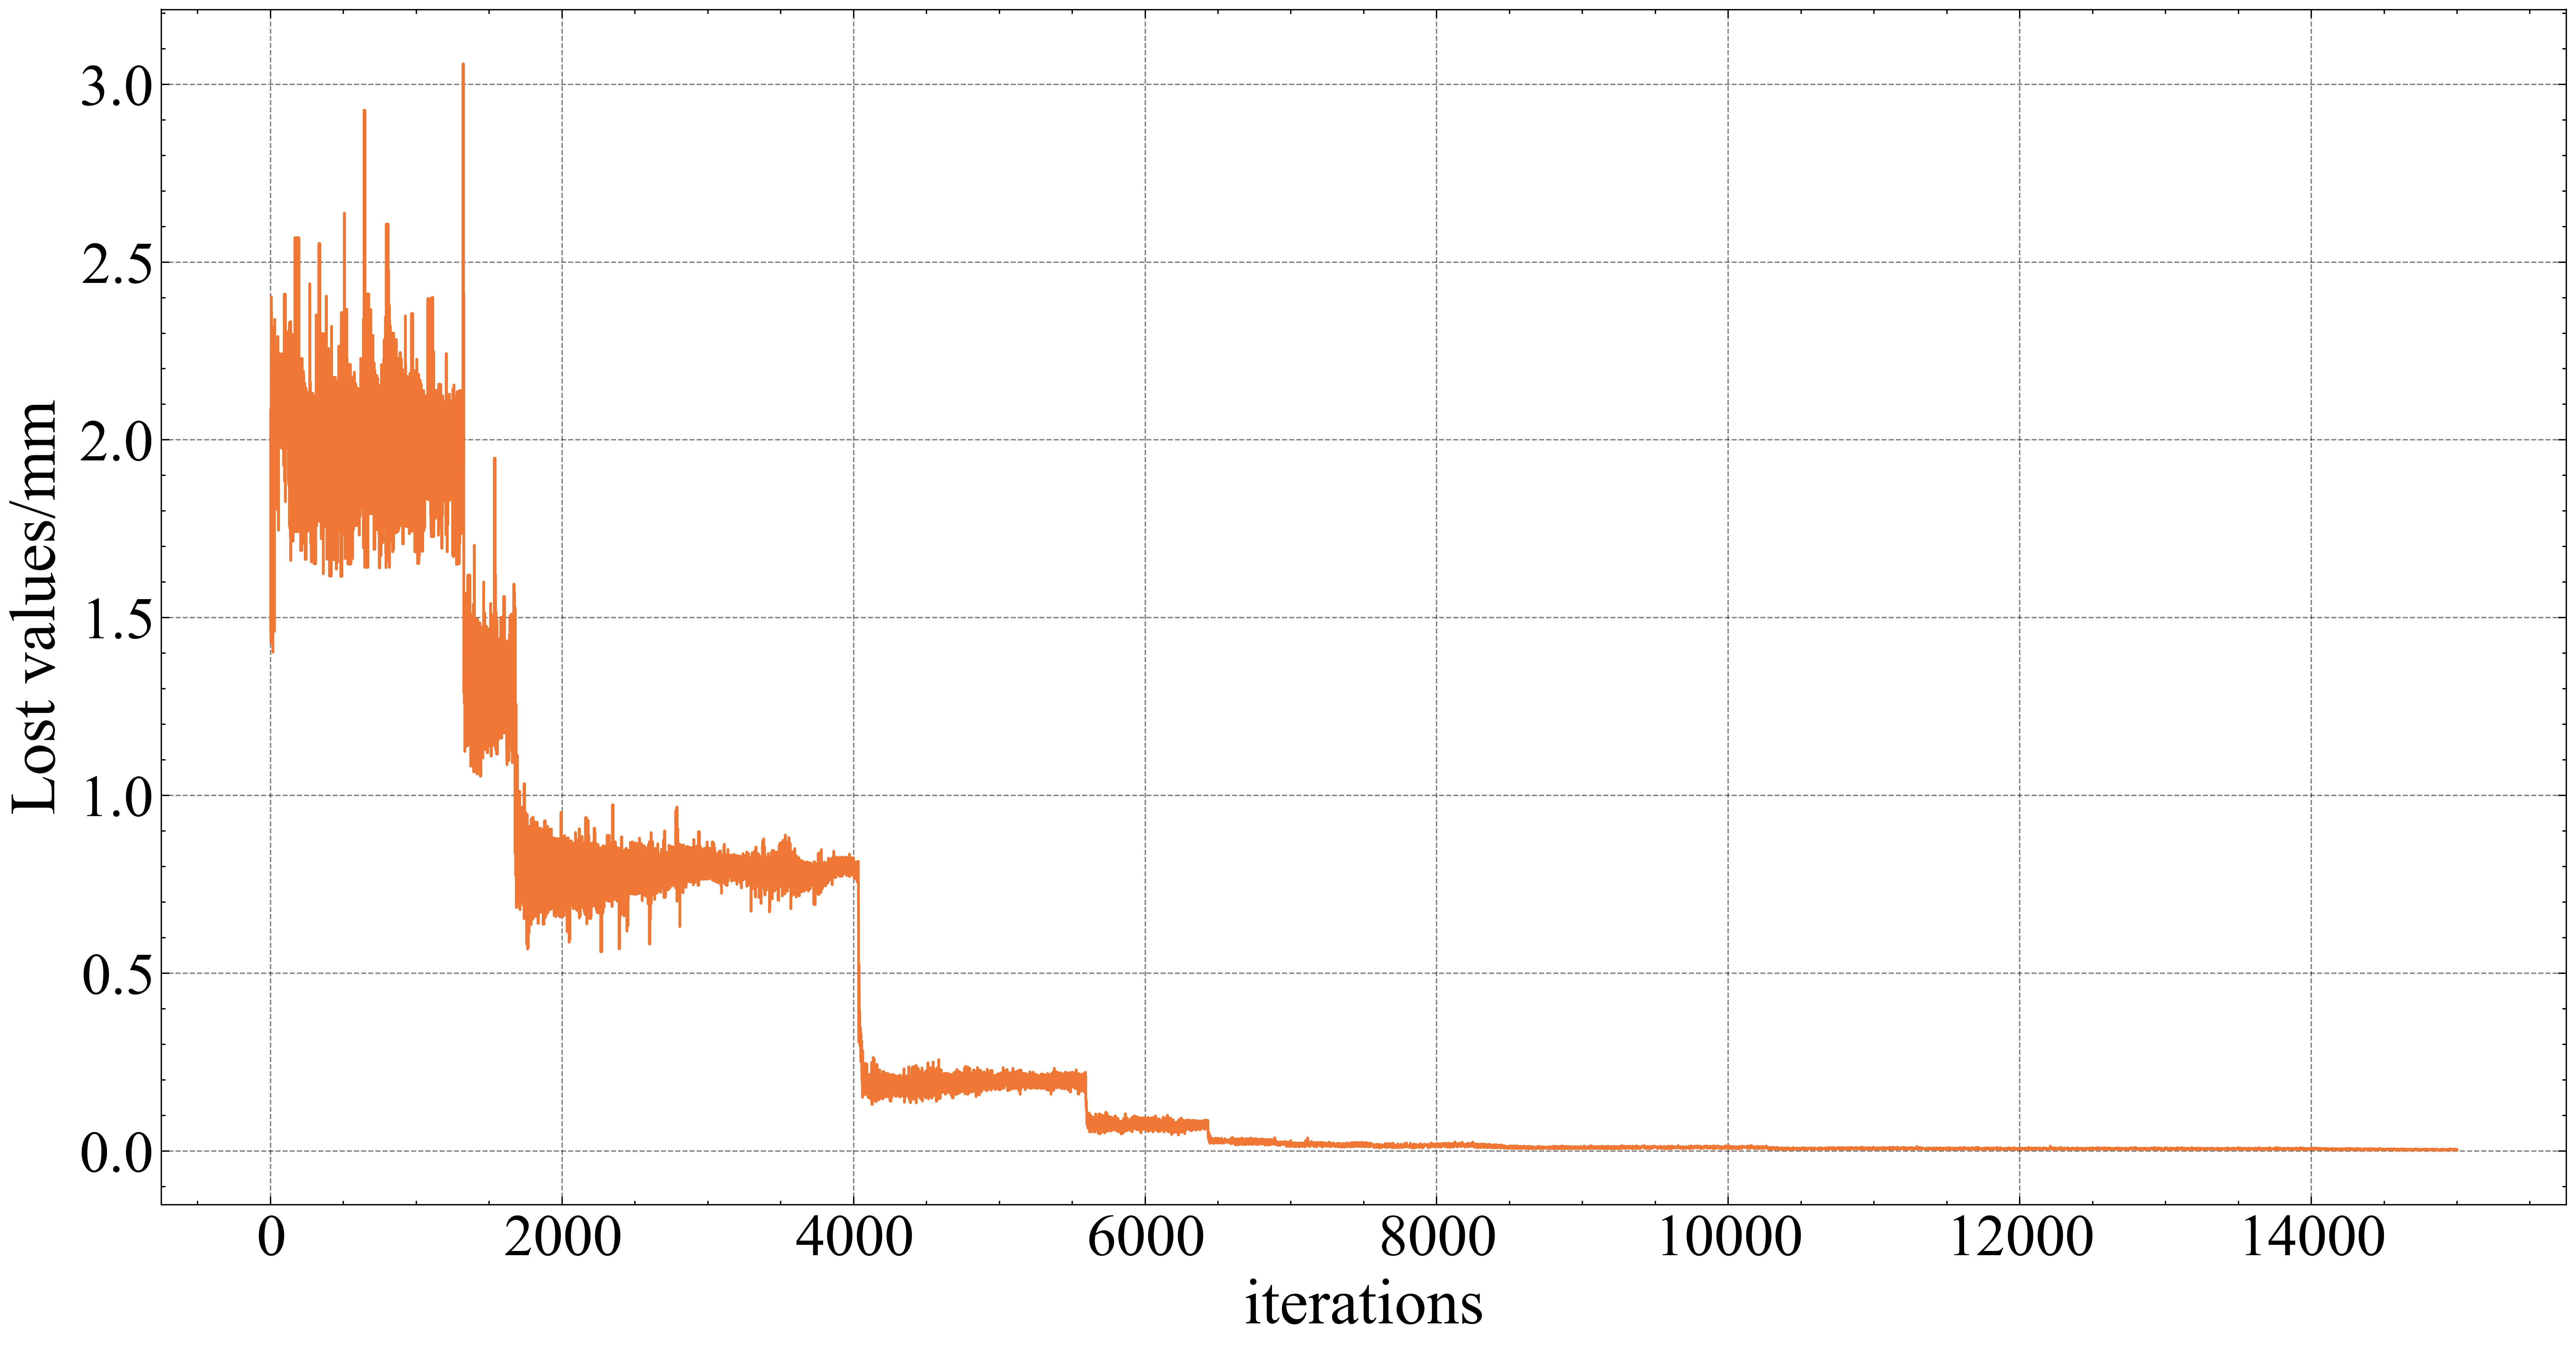

In [29]:
loss_arr_plot = tuple_rbf[3][:15000]
x_len = len(loss_arr_plot)
fontfamily = 'Times New Roman'

fs = 26
with plt.style.context(['science', 'ieee', 'vibrant', 'grid', 'no-latex']): 
    plt.figure(figsize =(16, 8))
    # plt.suptitle("Training process under the resolution of 30 m", fontsize=26, fontproperties=fontfamily, y=0.94)
    plt.plot(range(1, x_len+1), loss_arr_plot)
    plt.xlabel("iterations", fontsize=fs-2, fontproperties=fontfamily)
    plt.ylabel("Lost values/mm", fontsize=fs-2, fontproperties=fontfamily)
    plt.yticks(fontproperties = fontfamily, size = fs-4)
    plt.xticks(range(0, x_len, 2000), fontproperties = fontfamily, size = fs-4)
    # plt.legend(loc='best', ncol = 2, shadow = True, fancybox= True, prop={'family':'SimSun', 'size':fs-10})
    plt.savefig('loss_curve_second.jpg', dpi=300, bbox_inches='tight')
    plt.show()

In [32]:
import pickle

with open("rbf_model.pkl", "wb") as file:
    pickle.dump(tuple_rbf[4], file)

with open("rbf_model.pkl", "rb") as file:
    rbf_model = pickle.load(file)

In [38]:
from osgeo import gdal

rbf_x_norm,rbf_y_norm = tuple_rbf[-2], tuple_rbf[-1]

X_no_wd_dif = X_pd[labels].drop(['wd_dif', 'first_second_wd'], axis=1)
x_norm = rbf_x_norm.transform(X_no_wd_dif)
result, _ = rbf_model.predict(x_norm)
result_inversed = rbf_y_norm.inverse_transform(result.reshape(-1, 1))
result_final = (result_inversed + X_pd['first_second_wd'].values.reshape(-1, 1)).reshape(-1)
result_final = pd.Series(result_final, index=second_index)
y_true_result = X_pd[y_second_label] + X_pd['first_second_wd']
print(f'R2: {r2_score(y_true_result, result_final)}')
print(f'RMSE: {mean_squared_error(y_true_result, result_final, squared=False)}')
print(f'MAE: {mean_absolute_error(y_true_result, result_final)}')
print(f'MAD: {median_absolute_error(y_true_result, result_final)}')

data_base = r'./hx_30m'
start_num_row, end_num_row = 0, 284
start_num_col, end_num_col = 0, 210
rain_all_len = 33
rain_len = 27
data_len = (rain_all_len - rain_len + 1)

wd_class_index = []
data_len1 = (end_num_col-2) * (end_num_row-2)
wd_index_copy = second_index.copy().tolist()
for i in range(1, data_len+1):
    a = []
    while(True):
        if len(wd_index_copy)!=0 and wd_index_copy[0]//(data_len1*i) == 0:
            a.append(wd_index_copy[0])
            wd_index_copy.pop(0)
        else:
            break
    # print(a)
    wd_class_index.append(a)

data_f_result = pd.read_csv('data_f.csv')
for i in range(len(wd_class_index)):
    data_f_result.loc[wd_class_index[i], 'wd'] = result_final[wd_class_index[i]]

data_final_test = data_f_result.copy()
data_final_test['wd'] = 0
for i in range(len(wd_class_index)):
    data_final_test.loc[wd_class_index[i], 'wd'] = result_final[wd_class_index[i]]


data_len1 = (end_num_row-2)*(end_num_col-2)
rain_index = [range(data_len1*(i-1), data_len1*i) for i in range(1, data_len+1)]

data_f_result[data_f_result['wd']<0] = 0


input_tiff = gdal.Open(data_base + '/njhx/rain/result-0001.wd')

im_height = input_tiff.RasterYSize
im_width = input_tiff.RasterXSize
Type = input_tiff.GetRasterBand(1).DataType
Projection = input_tiff.GetProjection()
Transform = input_tiff.GetGeoTransform()
im_band = input_tiff.RasterCount

for i in range(7):
    result_tiff = r'GeoSimFlood_{}.tif'.format(str(i))
    driver = gdal.GetDriverByName("GTiff")
    sr = driver.Create(result_tiff, end_num_col, end_num_row, 1, Type)
    sr.GetRasterBand(1).WriteArray((data_f_result.loc[rain_index[i], 'wd']/1000).to_numpy().reshape(end_num_row-2, end_num_col-2))
    sr.SetGeoTransform(Transform)
    sr.SetProjection(Projection)
    sr.FlushCache()
    del sr

R2: 0.9465098012930657
RMSE: 7.892629927801082
MAE: 4.468108946955989
MAD: 1.8719584426551439


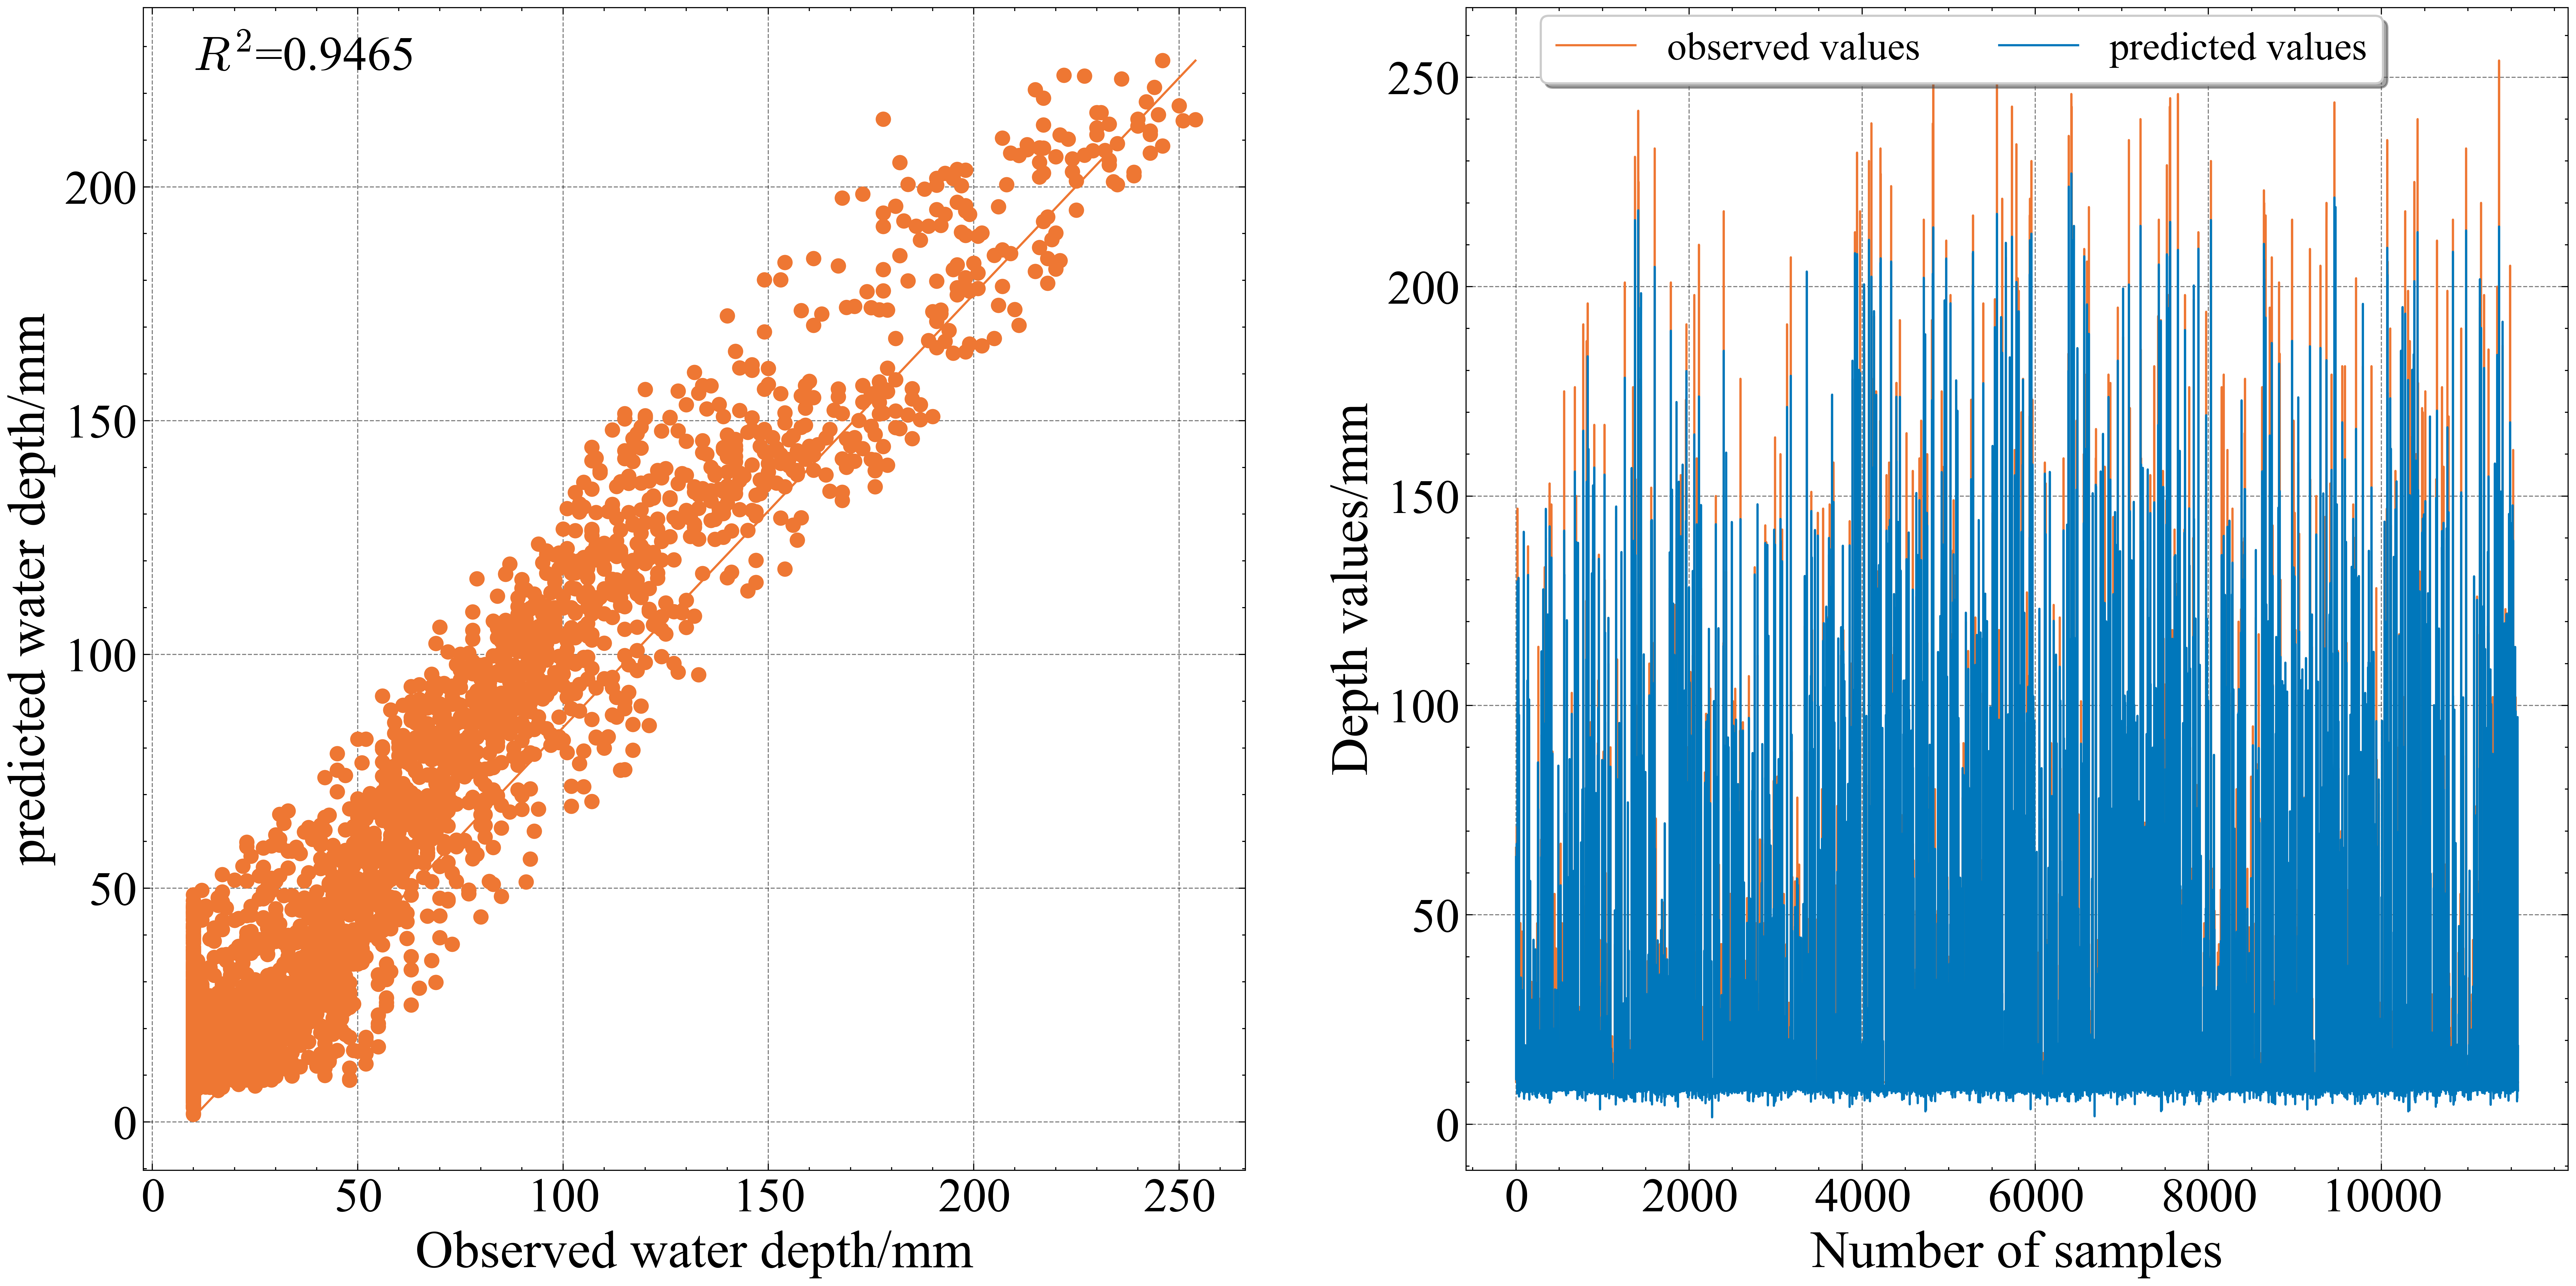

In [39]:
y1, y2 = y_true_result, result_final
r2 = r2_score(y1, y2)
x_len = np.arange(1, len(y1)+1)

with plt.style.context(['science', 'ieee', 'vibrant', 'grid', 'no-latex']): 
    plt.figure(figsize =(16, 8))
    plt.subplot(1, 2, 1)
    plt.tight_layout(pad=2)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=None, wspace=0.2)
    plt.scatter(y1, y2)
    x_min, x_max, y_min, y_max = int(y1.min()), int(y1.max()), int(y2.min()), int(y2.max())
    plt.plot(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    plt.xlabel("Observed water depth/mm", fontsize=fs-2, fontproperties=fontfamily)
    plt.ylabel("predicted water depth/mm", fontsize=fs-2, fontproperties=fontfamily)
    plt.yticks(fontproperties = fontfamily, size = fs-4)
    plt.xticks(fontproperties = fontfamily, size = fs-4)
    plt.text(x_min, y_max-2, '$R^2$={:.4f}'.format(r2), fontproperties=fontfamily, size=fs-4)
    plt.subplot(1, 2, 2)
    plt.xlabel("Number of samples", fontsize=fs-2, fontproperties=fontfamily)
    plt.ylabel("Depth values/mm", fontsize=fs-2, fontproperties=fontfamily)
    plt.yticks(fontproperties = fontfamily, size = fs-4)
    plt.xticks(range(0,len(y1), 2000), fontproperties = fontfamily, size = fs-4)
    plt.plot(x_len, y1, label='observed values')
    plt.plot(x_len, y2, label='predicted values')
    plt.legend(bbox_to_anchor=(0.05, 1.01), loc='upper left', ncol = 2, shadow = True, fancybox= True, prop={'family':fontfamily, 'size':fs-8})

    plt.savefig('true_pred_second.jpg', dpi=300, bbox_inches='tight')
    plt.show()

In [37]:
(0.9439-0.6473) / 0.6473

0.4582110304341109